<a href="https://colab.research.google.com/github/rakeshsurampalli/smart_investment/blob/master/ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [24]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


In [8]:
import pandas as pd
import numpy as np
from google.colab import files
from pandas import datetime
import matplotlib.pyplot as plt


In [9]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [10]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [11]:

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [12]:

#2. Get the file
downloaded = drive.CreateFile({'id':'1uXnme3jK0iwMN6tBujDWVU1Td2fj2k3T'}) # replace the id with id of file you want to access
downloaded.GetContentFile('RELIANCE20.csv')

In [13]:
import pandas as pd
sales = pd.read_csv('RELIANCE20.csv')

In [14]:
sales.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1996-01-01,16.009800,16.095699,15.904300,16.0683,2.412877,47600787.0
1,1996-01-02,16.029301,16.107401,15.826200,15.9434,2.394122,77143764.0
2,1996-01-03,16.205000,16.943001,16.029301,16.0644,2.412292,95695836.0
3,1996-01-04,15.912100,15.962900,15.701300,15.9160,2.390007,99159504.0
4,1996-01-05,15.853600,15.853600,15.670000,15.8067,2.373594,76213503.0


In [15]:
sales = sales.Close

In [66]:
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

MessageError: ignored

In [45]:
import io
def parser(x):
  return datetime.strptime(x,'%d/%m/%y')

sales = pd.read_csv(io.StringIO(uploaded['reliance1.csv'].decode('utf-8')),index_col=0,parse_dates=[0],date_parser=parser)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
sales.head()
print("checking if any null values are present\n", sales.isna().sum())

checking if any null values are present
 126


In [17]:
sales = sales.dropna()
print("checking if any null values are present\n", sales.isna().sum())

checking if any null values are present
 0


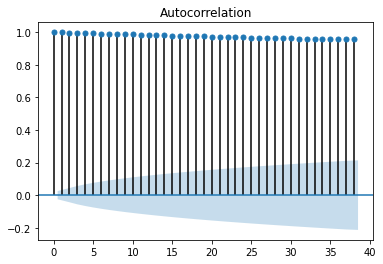

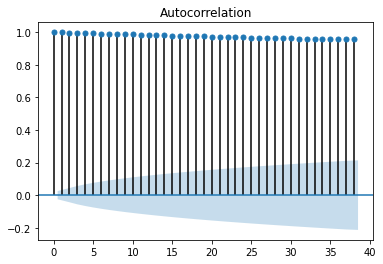

In [18]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(sales)

In [82]:
sales_diff = sales.diff(periods=1)

In [83]:
sales = sales_diff[1:]
sales.head()

1   -0.1249
2    0.1210
3   -0.1484
4   -0.1093
5   -0.6326
Name: Close, dtype: float64

In [40]:
 X = sales
#X = np.random.rand(32).astype(np.float32)+58
time = np.arange(6027)

print(X)
X.size
split_time = 5500
time_train = time[:split_time]
time_valid = time[split_time:]
x_train = X[:split_time]
x_test = X[split_time:]


0         16.068300
1         15.943400
2         16.064400
3         15.916000
4         15.806700
           ...     
6148    1431.550049
6149    1424.050049
6150    1445.550049
6151    1472.250000
6152    1464.400024
Name: Close, Length: 6027, dtype: float64


In [41]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [42]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train,window_size,batch_size = 128,shuffle_buffer = shuffle_buffer_size)

In [43]:
model = keras.models.Sequential([
                      keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1)),
                      #keras.layers.SimpleRNN(20, return_sequences = True,
                                               #input_shape = [None,1]),
                      keras.layers.Dense(20),
                      keras.layers.Dense(10),
                      keras.layers.Dense(1),
                      keras.layers.Lambda(lambda x: x*100.0)

               
])

In [44]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

In [45]:
optimizer = tf.keras.optimizers.SGD(lr=1e-8,momentum=0.9)

In [46]:
model.compile(loss=tf.keras.losses.Huber(),optimizer='adam',metrics=["mae"])

In [47]:
history = model.fit(train_set,epochs=136,callbacks=[lr_schedule])

Epoch 1/136

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

43/43 [==============================] - 1s 13ms/step - loss: 6925.2017 - mae: 6925.7017 - lr: 1.0000e-08
Epoch 2/136
43/43 [==============================] - 1s 12ms/step - loss: 6925.0015 - mae: 6925.5015 - lr: 1.1220e-08
Epoch 3/136
43/43 [==============================] - 1s 12ms/step - loss: 6924.7656 - mae: 6925.2656 - lr: 1.2589e-08
Epoch 4/136
43/43 [==============================] - 1s 12ms/step - loss: 6924.4385 - mae: 6924.9385 - lr: 1.4125e-08
Epoch 5/136
43/43 [=================

[[1063.4104 ]
 [1036.1453 ]
 [1021.2787 ]
 [ 997.60455]
 [1021.95197]
 [1023.80334]
 [1043.102  ]
 [1044.8411 ]
 [1041.6992 ]
 [1022.3448 ]
 [1009.1612 ]
 [1004.0559 ]
 [ 997.66064]
 [1005.6269 ]
 [1018.2498 ]
 [1002.2608 ]
 [1010.33923]
 [1008.8805 ]
 [ 989.6942 ]
 [1001.1949 ]
 [1008.60004]
 [1003.3825 ]
 [1018.3056 ]
 [1021.44727]
 [1027.0575 ]
 [1028.2352 ]
 [1043.7191 ]
 [1041.3064 ]
 [1052.6951 ]
 [1050.6758 ]
 [1058.7542 ]
 [1051.7417 ]
 [1056.566  ]
 [1040.409  ]
 [1049.4974 ]
 [1087.7018 ]
 [1088.2065 ]
 [1093.6486 ]
 [1117.1545 ]
 [1080.128  ]
 [1090.675  ]
 [1078.221  ]
 [1069.6375 ]
 [1088.7678 ]
 [1084.3918 ]
 [1095.1631 ]
 [1100.156  ]
 [1109.244  ]
 [1106.271  ]
 [1097.6879 ]
 [1072.1058 ]
 [1059.9883 ]
 [1047.0851 ]
 [1044.28   ]
 [1039.1189 ]
 [1022.8495 ]
 [1026.8888 ]
 [1032.4426 ]
 [1031.9941 ]
 [1028.6844 ]
 [1027.1696 ]
 [1033.0599 ]
 [1043.3827 ]
 [1054.9391 ]
 [1062.569  ]
 [1070.1422 ]
 [1089.1606 ]
 [1103.747  ]
 [1101.8391 ]
 [1118.1083 ]
 [1124.1111 ]
 [1130

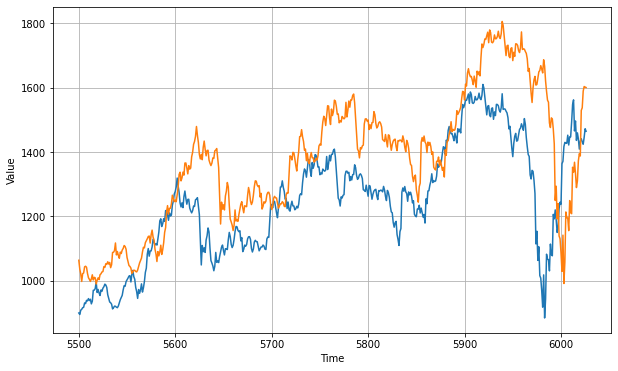

In [48]:
predictions = []
for time in range(len(X) - window_size):
  predictions.append(model.predict(X[time:time + window_size,np.newaxis]))

predictions = predictions[split_time-window_size:]
results = np.array(predictions)[:, 0, 0]
print(results)

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_test)
plot_series(time_valid, results)
